# Prepare trainning set from Simulation image

In [1]:
# data prep libaries
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

## CAD layout to detector position coordinate points

In [2]:
# Try with Rahul design thought process:
# outter/middle/inner ring: number of PDs +  ring diameter
class PD_array:
    def __init__(self, sub_inner_ring_size, inner_ring_size, middle_ring_size, outer_ring_size,
                 sub_inner_ring_count, inner_pd_count, middle_pd_count, outer_pd_count):
        """
        Initialize PD_Array with ring sizes and number of photodetectors each ring.
        
        Args:
            inner/middle/outer_ring_size (float): Diameter of the inner/mid/outer ring. unit: mm
            inner/middle/outer_pd_count (int): Number of PDs in inner/mid/outer ring
        """
        self.ring_sizes = [sub_inner_ring_size,inner_ring_size, middle_ring_size, outer_ring_size]
        self.pd_counts = [sub_inner_ring_count, inner_pd_count, middle_pd_count, outer_pd_count]
        self.coordinates = None
        self.get_coordinates()

    def get_coordinates(self):

        coordinates = []
        
        # convert to xy coordinates
        for ring_idx, (diameter, pd_count) in enumerate(zip(self.ring_sizes, self.pd_counts)):
            # Calculate angular spacing for this ring
            angles = np.linspace(np.pi/2, 2.5 * np.pi, pd_count, endpoint=False)
            
            # Calculate x and y coordinates
            x_coords = (diameter/2) * np.cos(angles)
            y_coords = (diameter/2) * np.sin(angles)
            
            # Combine x and y coordinates
            ring_coords = np.column_stack((x_coords, y_coords))
            coordinates.append(ring_coords)
        
        # Combine all coordinates into a single array
        self.coordinates = np.vstack(coordinates)
        return np.vstack(coordinates)


In [3]:
#### 4/7 layouts follows: 3 ring, 32 diods
# PD_array(in_size,mid_size_out_size,in_mid_out_number)
layout_1 = PD_array(0,9.1,13.75,18.25,0,7,11,14)  ## part #: PRT-0015
layout_2 = PD_array(0,8.65,12.95,17.15,0,7,11,14) ## part #:PRT-0012
layout_3 = PD_array(5.45,10.3,14.85,19,4,6,11,11) ## part #:PRT-0014
layout_4 = PD_array(5.15,9.65,13.9,17.8,4,6,11,11) ## part #:PRT-0017
layouts_ls = [layout_1,layout_2,layout_3,layout_4]

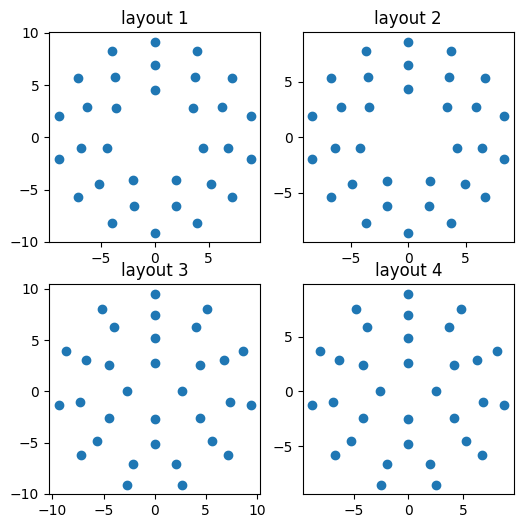

In [4]:
# Plot the corrdinates making sure it's all correct
plt.figure(figsize=(6,6))
for layout_idx in range(len(layouts_ls)):
    plt.subplot(2, 2, layout_idx+1)
    plt.scatter(layouts_ls[layout_idx].coordinates[:,0],layouts_ls[layout_idx].coordinates[:,1])
    # plt.xlabel('coordinate x in mm')
    # plt.ylabel('coordinate y in mm')
    plt.title(f"layout {layout_idx + 1}")


## sample on simulation image (TEST+VAL sets)

/home/aquila-nazar/observer_dev/PD_layout_val/data/sim_data


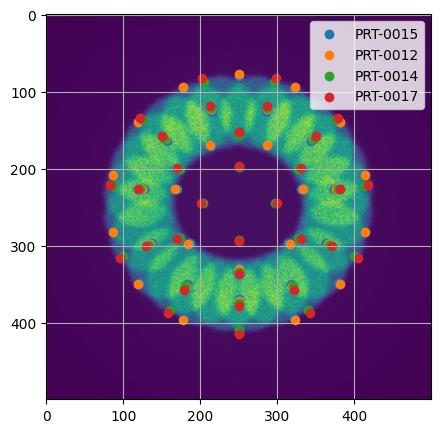

In [5]:
## load sim data ##
current_dir = Path.cwd()
parent_dir = current_dir.parent
# Access the file in the parent directory
data_root = parent_dir / "data/sim_data"
print(data_root)
# load and compare the PD size and ring size
for file in os.listdir(data_root):
    if file.endswith('nominal.csv'):
        retro_img = np.loadtxt(os.path.join(data_root,file),delimiter=',')
        plt.figure(figsize=(5,5))
        plt.imshow(retro_img)
        # Resize the PD coordinate to the simulation ring image size (520*520 pixels)
        sample_pnts_1 = ((layout_1.coordinates/layout_1.coordinates.max())*165 +(250,245)).round()
        sample_pnts_2 = ((layout_2.coordinates/layout_2.coordinates.max())*168 +(250,245)).round()
        sample_pnts_3 = ((layout_3.coordinates/layout_3.coordinates.max())*165 + (250,245)).round()
        sample_pnts_4 = ((layout_4.coordinates/layout_4.coordinates.max())*170 + (250,245)).round()
        plt.scatter(sample_pnts_1[:,0],sample_pnts_1[:,1],label='PRT-0015')
        plt.scatter(sample_pnts_2[:,0],sample_pnts_2[:,1],label='PRT-0012')
        plt.scatter(sample_pnts_3[:,0],sample_pnts_3[:,1],label='PRT-0014')
        plt.scatter(sample_pnts_4[:,0],sample_pnts_4[:,1],label='PRT-0017')
        plt.legend()
        plt.grid()

In [6]:
## sample on the sim image
diod_array_lst = [sample_pnts_1,sample_pnts_2,sample_pnts_3,sample_pnts_4]
for idx,diod_array in enumerate(diod_array_lst):
    in_set=[]
    for file in os.listdir(data_root):
        if file.endswith('.csv'):
            if file.startswith('nominal'):
                continue
            image = np.loadtxt(os.path.join(data_root,file),delimiter=',')
            sample_on_img = []
            for diod in diod_array:        
                sample_on_img.append(image[int(diod[0]),int(diod[1])])
            in_set.append(sample_on_img)
    in_set = np.array(in_set)

    # print in_set shape
    print(in_set.shape)
    # make target set
    tar_set = np.array([(x, y) for x in np.arange(-8, -6.5, 0.5) for y in np.arange(-8, 8, 0.5)])

    # save input set as csv for later inspection
    train_set_filename = f'layout_{idx + 1}'
    np.savetxt(train_set_filename +'_input.csv', in_set, delimiter=',')  
    
    # save (in,tar) as .pt for faster data loading in training
    in_tensor = torch.tensor(in_set, dtype=torch.float32)
    tar_set = torch.tensor(tar_set, dtype=torch.float32)
    data_tensor = (in_tensor, tar_set)
    torch.save(data_tensor, train_set_filename+'_train_set.pt')             
                

(96, 32)


KeyboardInterrupt: 

In [7]:
# input set statistics
# print in_set statistics
## layout 1
print(in_set[:,0].shape)
print(in_set[:,0].mean())
print(in_set[:,0].std())



(96,)
6.3099660208333335
0.14332678381121305


# structure new model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import os 

In [8]:
class PD32DNN_1(nn.Module):
    def __init__(self):
        super(PD32DNN_1, self).__init__()        
        # Define the layers
        self.in2hid1 = nn.Linear(32, 16)
        self.hid1 = None
        self.hid2 = None
        self.hid3 = None
        self.hids = nn.Linear(16,8)
        self.hidss = nn.Linear(8,4)
        self.hid2out = nn.Linear(4, 2)

       # Store mean and std for normalization
        self.mean = torch.tensor(6.31).float()
        self.std = torch.tensor(0.14).float()

    def normalise(self, input):
        # Normalize input using stored mean and std
        return (input - self.mean.to(input.device)) / self.std.to(input.device)
    
    def forward(self, input):
        normed_input = self.normalise(input)
        self.hid1 = F.leaky_relu(self.in2hid1(normed_input))
        self.hid2 = F.relu(self.hids(self.hid1))
        self.hid3 = F.leaky_relu(self.hidss(self.hid2))
        out = F.leaky_relu(self.hid2out(self.hid3))
        return out

In [11]:
class SimDat(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.in_set, self.tar_set = torch.load(self.data_path)
    
    def __len__(self):
        return len(self.tar_set)

    def __getitem__(self, idx):
        return self.in_set[idx], self.tar_set[idx]

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()        # zero the gradients
        output = model(data)         # apply network
        loss = F.mse_loss(output, target) #loss fucntion as mse/huber  
        loss.backward()              # compute gradients
        optimizer.step()             # update weights
        
        if epoch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test():
    pass

In [15]:
PRT_15_net = PD32DNN_1().to('cuda')
PRT_15_dataset = SimDat('layout_1_train_set.pt')

device = 'cuda'
optimizer = torch.optim.Adam(PRT_15_net.parameters(),lr=0.008,
                        weight_decay=0.0008)

train_loader = torch.utils.data.DataLoader(PRT_15_dataset,
                            batch_size=96) 
for epoch in range(1, 300):
    train(PRT_15_net,device,train_loader,optimizer,epoch)

/tmp/ipykernel_26047/2282574659.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.in_set, self.tar_set = torch.load(self.data_path)


Train Epoch: 100 [0/96 (0%)]	Loss: 10.758914947509766
Train Epoch: 200 [0/96 (0%)]	Loss: 10.754664421081543


In [22]:
def export_model(model, device='cuda', save_path="layout1_model", input_shape=(1,32)):
    # Save PyTorch model
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': model.__class__.__name__
    }, f"{save_path}.pth")
    
    # Prepare model for ONNX export
    model.eval()    
    # Create dummy input tensor
    dummy_input = torch.randn(input_shape, device=device)
    
    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        f"{save_path}.onnx",
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model saved as {save_path}.pth and {save_path}.onnx")

In [23]:
export_model(PRT_15_net)

Model saved as layout1_model.pth and layout1_model.onnx
